# Data Scientist Technical Test
### David Rodríguez Segado

**Initial Note**

The chunks of this notebook have not been executed in total order (because re-executions were needed). Nonetheless, the chunks are meant to be executed in sequential order.

In [1]:
# Loading Libraries Module #
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import multiprocessing

from IPython.display import display, Markdown
from joblib import Parallel, delayed
from mlxtend.evaluate import permutation_test
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Loading Data Module #
# Paths should be modified to replicate #
ex_1 = pd.read_csv("data_exercise1.csv")
ex_2_train = pd.read_csv("train.csv")
ex_2_test = pd.read_csv("test.csv")
ex_2_sample = pd.read_csv("sample_submission.csv")

In [4]:
# Tunning Values #
NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
NUM_CPUS = multiprocessing.cpu_count() - 1
RESAMPLE_SIZE = min(ex_1.groupby("type").apply(lambda x: len(x)))
RESAMPLES = 100000
pd.set_option('display.max_rows', 500)

In [17]:
# Functions #
def bp_hist_fun(df, title=None):
    """
    Function that displays a combination of boxplot and histogram plots where all the columns are the target variable according to each level of the categorical variable studied 
    """
    fig1, f1_axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(16, 8))
    df_aux = pd.melt(df)
    sns.boxplot(x="variable", y="value", data=df_aux, ax=f1_axes[0])
    for type_i in df_aux["variable"].unique():
        sns.distplot(df_aux[df_aux["variable"]==type_i]["value"],
                     label=type_i, hist=True, ax=f1_axes[1], vertical=True, kde=False)
    if title:
        fig1.suptitle(title)
    plt.legend()
    plt.show() 

def qcd(array):
    """
    Function that calculates the quartile coefficient of dispersion of an array
    """
    return (np.percentile(array, 75) - np.percentile(array, 25)) / (np.percentile(array, 75) + np.percentile(array, 25))

def preprocess_df(df, train=False):
    """
    Function that modifies a dataframe (coming from the provided data) to modify and create variables.
    """
    if isinstance(df["join_date"][0], str):
        df["join_date"] = df.apply(lambda x: datetime.datetime.strptime(x["join_date"], '%Y-%m-%d %H:%M:%S'), axis=1)
    
    df["join_date_all_day"] = df.apply(lambda x: x["join_date"].strftime("%Y-%m-%d"), axis=1)
    
    df["join_date_day"] = df.apply(lambda x: x["join_date"].weekday(), axis=1)
    
    df["join_date_labour"] = np.where(df["join_date_day"] > 4, 'weekend', 'labour')
    
    df["join_date_month"] = df.apply(lambda x: x["join_date"].month, axis=1)
    
    df["join_date_year"] = df.apply(lambda x: x["join_date"].year, axis=1)

    df["is_cancelled"] = df["is_cancelled"].fillna("Not Acknowledged")
    
    if train:
        df["frau"] = np.where(df["target"] < 0, 'fraudulent', 'cool')
    
    return df

## First Exercise

### Question 1: Which metric would you use to compare the two distributions?

Before answering this question, let's check the distribution values, the main summary statistics and normalty test in order to get insights of the distribution.

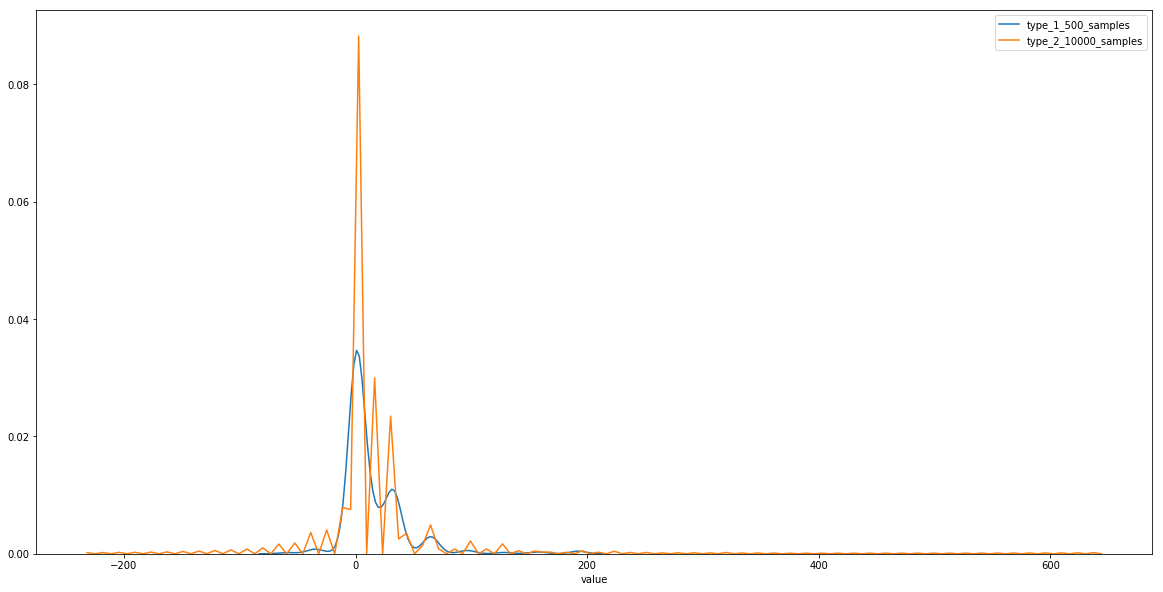

In [6]:
fig = plt.figure(figsize=(20,10))
for type_i in ex_1["type"].unique():
    sns.distplot(ex_1[ex_1["type"]==type_i]["value"], 
                 label=type_i, hist=False)
plt.legend()
plt.show()

In [7]:
display(ex_1.groupby("type").describe())

value                                                 \
                        count       mean        std        min    25%    50%   
type                                                                           
type_1_500_samples      500.0  15.122863  29.391383  -62.39475  0.795  1.590   
type_2_10000_samples  10000.0  13.850097  34.290446 -226.03425  0.795  0.795   

                                          
                           75%       max  
type                                      
type_1_500_samples    31.76025  192.9465  
type_2_10000_samples  16.50000  638.3850

In [9]:
test = stats.jarque_bera(ex_1[ex_1["type"]=="type_1_500_samples"]["value"].values)

Markdown("The Statistic of the Jarque Bera normality test for type_1_500_samples is {:.2f}, with a p_value of {:.2f}".format(test[0], test[1]))

The Statistic of the Jarque Bera normality test for type_1_500_samples is 4314.87, with a p_value of 0.00

In [10]:
test = stats.jarque_bera(ex_1[ex_1["type"]=="type_2_10000_samples"]["value"].values)

Markdown("The Statistic of the Jarque Bera normality test for type_2_10000_samples is {:.2f}, with a p_value of {:.2f}".format(test[0], test[1]))

The Statistic of the Jarque Bera normality test for type_2_10000_samples is 493477.57, with a p_value of 0.00

The main insights that may affect are:
- *Type 2* has much more values than *Type 1*.
- *Type 2* and *Type 1* have the same first quartile (25%), while *Type 2* is bigger in maximum and *Type 1* in the rest of quartiles.
- The standard deviation is slightly lower in *Type 2* while the mean is slightly higher in *Type 1*.
- None of the distributions follow significantly a normal distribution. Transform data using logarithms or square root is not allowed because of negative values.

The thing is, mean and standard deviation values are sensible to extreme values, what specially *Type 2* has. 

So,
- **T-statistic** (even for standard t-test or for welch t-test, which works for unequal sized samples or variances) is **discarded** because of non-normality. 
- **Mean** and **standard deviation values** are **discarded** because of extreme values.

Then, my options would be:
- The **Median**, because is a central location metric more robust tot he exposed issues. Furthermore, it shows that "50% of the values are this value or higher".
- The **Quartile Coefficient of Dispersion**, because is a variability metric mor robust to exposed issues.

However, I would use all the "discarded" metrics with permutation tests.

### Question 2: Is there a graphical way to compare the distributions?

A combination of histogram (shown in question 1 as density plot) with boxplot allows to check the distribution of the values while showing the main location measure statistics. Therefore, it can be used to check differences between distributions.

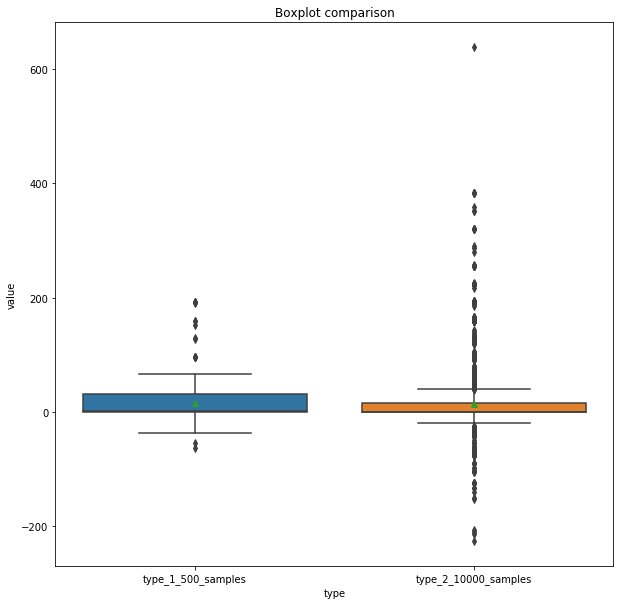

In [12]:
fig = plt.figure(figsize=(10,10))
sns.boxplot(x="type", y="value", data=ex_1, showmeans=True)
plt.title("Boxplot comparison")
plt.show()

Nonetheless, it has been exposed that same sizes are unequal and there are extrem values. Then, I would squeeze the data to (-----) using resampling methods. With this I would be able to see the sampling distribution of the statistics of interest, allowing to see if the distribution of the statistic of interest is significantly higher than the other. To take in consideration the different in sample sizes, I've decided to extract samples with resampling, using the sample size of the little group.

In [14]:
type1_resamples = Parallel(n_jobs=NUM_CPUS)(
    delayed(np.random.choice)(
        a = ex_1[ex_1["type"]=="type_1_500_samples"]["value"],
        size = RESAMPLE_SIZE
    ) for perm in range(RESAMPLES))

type2_resamples = Parallel(n_jobs=NUM_CPUS)(
    delayed(np.random.choice)(
        a = ex_1[ex_1["type"]=="type_2_10000_samples"]["value"],
        size = RESAMPLE_SIZE
    ) for perm in range(RESAMPLES))

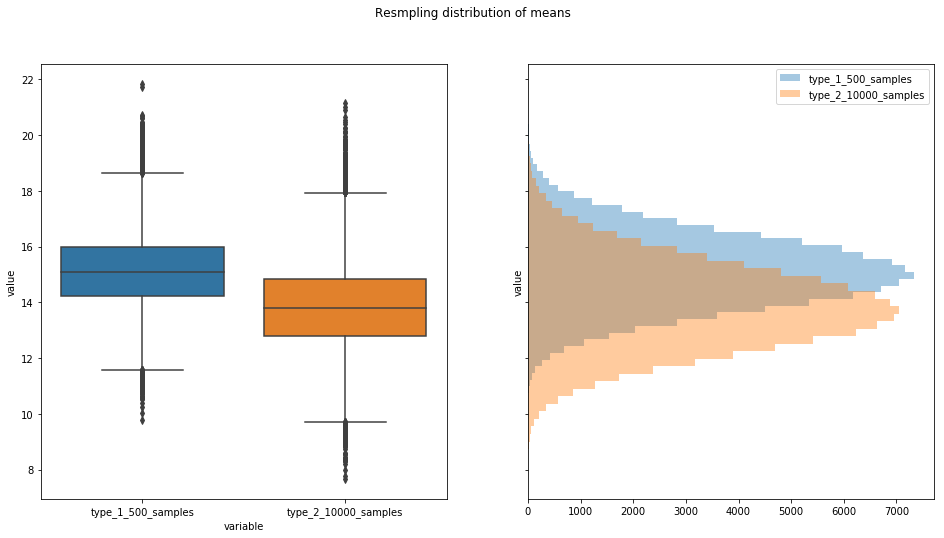

In [18]:
bp_hist_fun(
    pd.DataFrame({"type_1_500_samples": map(np.mean, type1_resamples),
                  "type_2_10000_samples": map(np.mean, type2_resamples)}),
    title="Resmpling distribution of means")

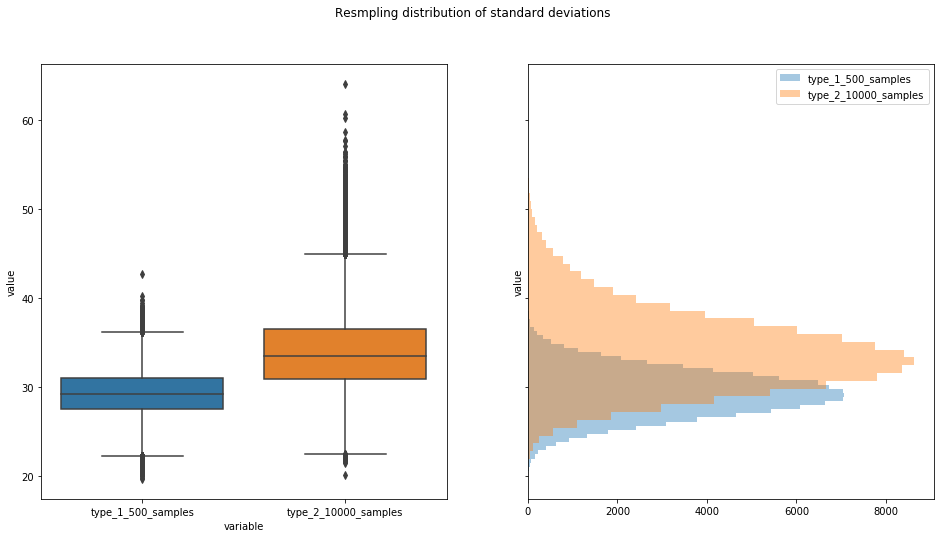

In [19]:
bp_hist_fun(
    pd.DataFrame({"type_1_500_samples": map(np.std, type1_resamples),
                  "type_2_10000_samples": map(np.std, type2_resamples)}),
    title="Resmpling distribution of standard deviations")

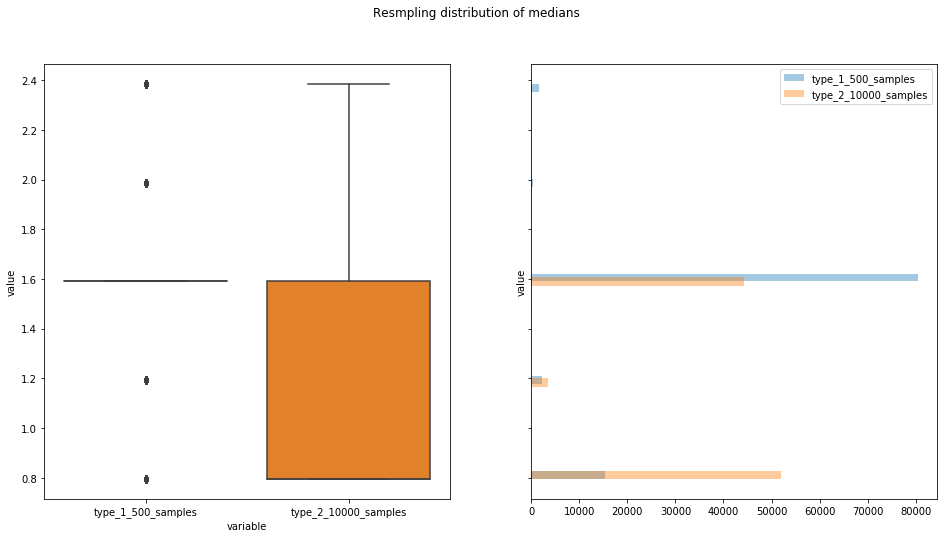

In [20]:
bp_hist_fun(
    pd.DataFrame({"type_1_500_samples": map(np.median, type1_resamples),
                  "type_2_10000_samples": map(np.median, type2_resamples)}),
    title="Resmpling distribution of medians")

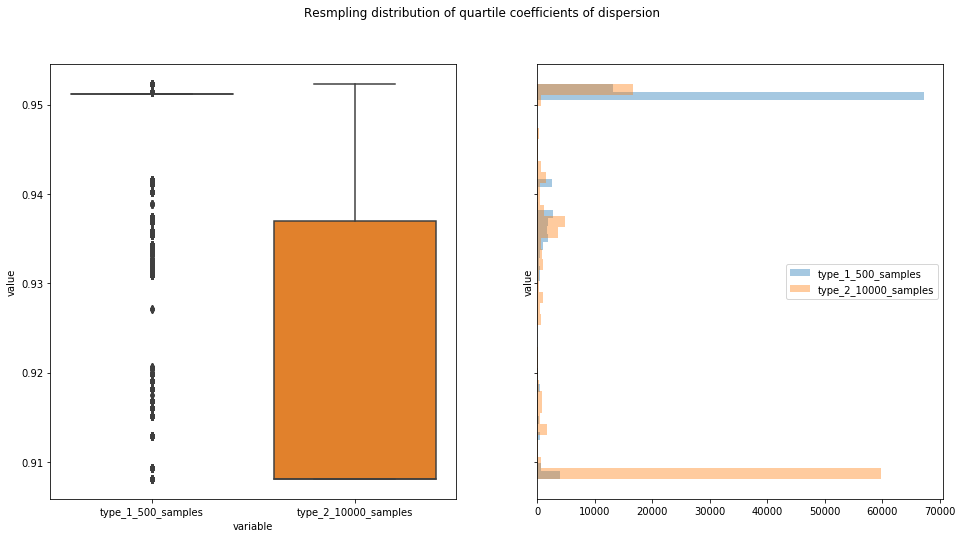

In [21]:
bp_hist_fun(
    pd.DataFrame({"type_1_500_samples": map(qcd, type1_resamples),
                  "type_2_10000_samples": map(qcd, type2_resamples)}),
    title="Resmpling distribution of quartile coefficients of dispersion")

Visually, all these inputs show that type 1 tends to have higher distribution of values. Nonetheless, statistical tests are required to check if the difference is statisticall significant. 

### Question 3: How would you design a statistical test for this problem? How would you overcome the problem of the different sample size?

Following what has been exposed in the previous two questions and to avoid this problem, a non-parametric test should be applied. For that, I'm using two approaches (various indicators will help to reach better conclusions):
- "Classical" non-parametric tests
- Permutation test

For all the hypothesis contrasts, the Null Hypothesis is the equality between both distributions.

In [26]:
test = stats.mannwhitneyu(
    x=ex_1[ex_1["type"]=="type_1_500_samples"]["value"],
    y=ex_1[ex_1["type"]=="type_2_10000_samples"]["value"], 
    alternative="two-sided")

Markdown("The Statistic of the Mann-Whitney-U test is {:.2f}, with a p_value of {:.4f}".format(test[0], test[1]))

The Statistic of the Mann-Whitney-U test is 2590027.50, with a p_value of 0.1544

In [27]:
test = stats.kruskal(
    ex_1[ex_1["type"]=="type_1_500_samples"]["value"].values,
    ex_1[ex_1["type"]=="type_2_10000_samples"]["value"].values)

Markdown("The Statistic of the Kruskal Wallis test is {:.2f}, with a p_value of {:.4f}".format(test[0], test[1]))

The Statistic of the Kruskal Wallis test is 2.03, with a p_value of 0.1544

In [28]:
Markdown("The p_value of the permutation test comparing mean values is: {:.4f}".format(
        permutation_test(ex_1[ex_1["type"]=="type_1_500_samples"]["value"].values,
                         ex_1[ex_1["type"]=="type_2_10000_samples"]["value"].values,
                         method="approximate", num_rounds=RESAMPLES, seed=0,
                         func=lambda x, y: np.abs(np.mean(x) - np.mean(y))))
        )

The p_value of the permutation test comparing mean values is: 0.4133

In [29]:
Markdown("The p_value of the permutation test comparing standard deviation values is: {:.4f}".format(
        permutation_test(ex_1[ex_1["type"]=="type_1_500_samples"]["value"].values,
                         ex_1[ex_1["type"]=="type_2_10000_samples"]["value"].values,
                         method="approximate", num_rounds=RESAMPLES, seed=0,
                         func=lambda x, y: np.abs(np.std(x) - np.std(y))))
        )

The p_value of the permutation test comparing standard deviation values is: 0.2580

In [30]:
Markdown("The p_value of the permutation test comparing median values is: {:.4f}".format(
        permutation_test(ex_1[ex_1["type"]=="type_1_500_samples"]["value"].values,
                         ex_1[ex_1["type"]=="type_2_10000_samples"]["value"].values,
                         method="approximate", num_rounds=RESAMPLES, seed=0,
                         func=lambda x, y: np.abs(np.median(x) - np.median(y))))
        )

The p_value of the permutation test comparing median values is: 0.0001

In [31]:
Markdown("The p_value of the permutation test comparing quartile coefficient of dispersion values is: {:.4f}".format(
        permutation_test(ex_1[ex_1["type"]=="type_1_500_samples"]["value"].values,
                         ex_1[ex_1["type"]=="type_2_10000_samples"]["value"].values,
                         method="approximate", num_rounds=RESAMPLES, seed=0,
                         func=lambda x, y: np.abs(qcd(x) - qcd(y))))
        )

The p_value of the permutation test comparing quartile coefficient of dispersion values is: 0.0065

In [32]:
Markdown("The p_value of the permutation test using welch t-test statistic values is: {:.4f}".format(
        permutation_test(ex_1[ex_1["type"]=="type_1_500_samples"]["value"].values,
                         ex_1[ex_1["type"]=="type_2_10000_samples"]["value"].values,
                         method="approximate", num_rounds=RESAMPLES, seed=0,
                         func=lambda x, y: stats.ttest_ind(x, y, equal_var=False)))
        )

The p_value of the permutation test using welch t-test statistic values is: 0.1587

The combination of the tests are pointing into the same direction (except for median and quartile coefficient of dispersion permutation tests, that conjoint with weird distributions) , there are no significant evidences to determine that one of the distributions differs from the other. Nonetheless, all the conclusions are extracted from the initial sample. A replica of this analysis and/or new samples of data should confirm that this is true.

## Second Exercise

### Question 1: Exploratory Data Analysis

Noticing that there's a timestamp variable, it may be interesting to check if there are differences across months, years and days. In addition, NaN values may be found in *is_cancelled*, which are the cases that are not yet ackownledged, for that, the NaN values will be a new category called "Not Acknowledged".

In [35]:
## Data pre-processing #
ex_2_train = preprocess_df(ex_2_train, train=True)

cat = ["join_date_labour", "join_date_day", "join_date_month", "join_date_year", "credit_card_level", "aff_type", "country_segment", "product_type", "hidden", "is_cancelled", "product"]
num = ["STV"]

ex_2_train.head()

product_type  user_id           join_date  hidden    product   STV  target  \
0      type_ex      7.0 2018-12-01 00:01:45       0  product_1  8.25    8.25   
1      type_ex     20.0 2018-12-01 00:06:05       0  product_2  8.25    8.25   
2      type_ex     22.0 2018-12-01 00:06:23       0  product_3  8.25    8.25   
3      type_ex     26.0 2018-12-01 00:07:12       0  product_2  8.25    8.25   
4      type_ex     59.0 2018-12-01 00:15:21       0  product_2  8.25    8.25   

  credit_card_level  is_lp aff_type      is_cancelled  country_segment  \
0          standard      0      PPL  Not Acknowledged               US   
1          standard      0      PPL  Not Acknowledged               US   
2           prepaid      0      PPL  Not Acknowledged               US   
3          standard      0      PPL  Not Acknowledged               US   
4          standard      0      PPL  Not Acknowledged  Other Countries   

  join_date_all_day  join_date_day join_date_labour  join_date_month  \
0        2018-12-01              5          weekend               12   
1        2018-12-01              5          weekend               12   
2        2018-12-01              5          weekend               12   
3        2018-12-01              5          weekend               12   
4        2018-12-01              5          weekend               12   

   join_date_year  frau  
0            2018  cool  
1            2018  cool  
2            2018  cool  
3            2018  cool  
4            2018  cool

Except for STV and the target itself, there are no numerical variables. So, I'm showing boxplots from each level of the cathegorical variables. In order to check if there are visible differences between them.

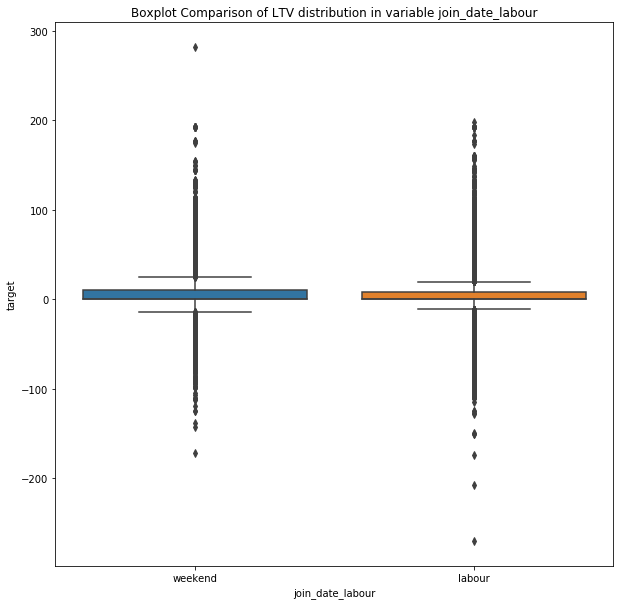

Summary Statistics of LTV according to join_date_labour


count      mean        std       min     25%     50%  \
join_date_labour                                                            
labour            598024.0  6.212941  14.516004 -270.2035  0.3975  0.3975   
weekend           283103.0  6.453352  14.837174 -171.3467  0.3975  0.7950   

                       75%       max  
join_date_labour                      
labour             8.25000  198.0544  
weekend           10.31513  281.8116

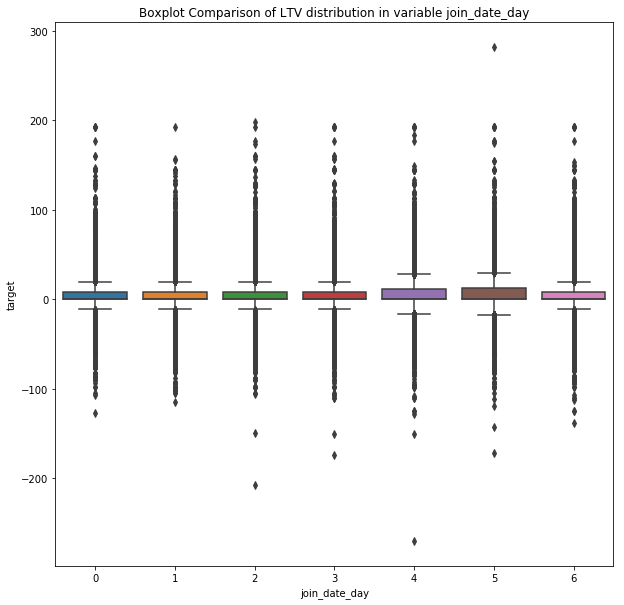

Summary Statistics of LTV according to join_date_day


count      mean        std       min     25%     50%  \
join_date_day                                                            
0              125523.0  6.247483  14.485770 -127.1696  0.3975  0.3975   
1              118242.0  6.119090  14.414380 -114.2948  0.3975  0.3975   
2              116195.0  6.104974  14.478982 -207.0510  0.3975  0.3975   
3              117327.0  6.185562  14.449646 -174.4742  0.3975  0.3975   
4              120737.0  6.399455  14.743017 -270.2035  0.3975  0.7950   
5              140027.0  6.545468  14.897461 -171.3467  0.3975  0.7950   
6              143076.0  6.363199  14.777430 -138.0345  0.3975  0.3975   

                    75%       max  
join_date_day                      
0               8.25000  192.1515  
1               8.25000  192.1515  
2               8.25000  198.0544  
3               8.25000  192.1515  
4              11.50763  192.1515  
5              12.18275  281.8116  
6               8.25000  192.1515

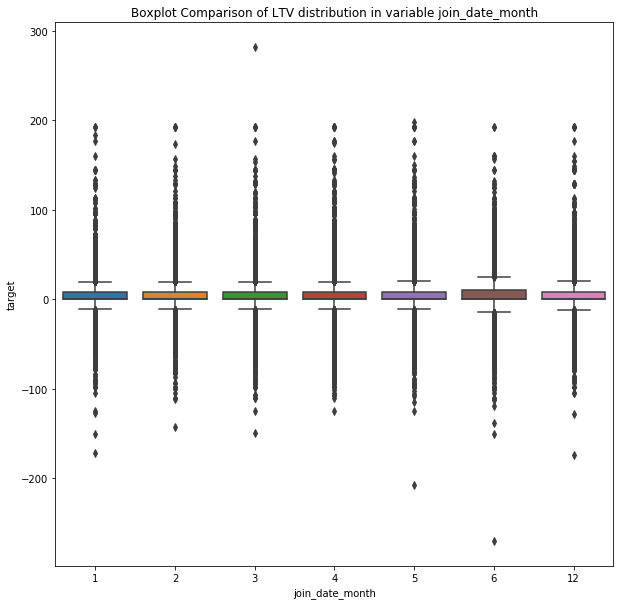

Summary Statistics of LTV according to join_date_month


count      mean        std       min     25%     50%  \
join_date_month                                                            
1                121416.0  6.105508  13.819465 -171.3467  0.3975  0.3975   
2                121860.0  6.299977  14.203957 -142.3844  0.3975  0.7950   
3                137695.0  6.345600  14.658412 -149.4845  0.3975  0.7950   
4                126251.0  6.273053  15.058949 -124.7895  0.3975  0.7950   
5                127013.0  6.191286  14.945064 -207.0510  0.3975  0.3975   
6                118104.0  6.289229  15.513344 -270.2035  0.3975  0.5900   
12               128788.0  6.510983  14.085821 -174.4742  0.3975  0.3975   

                      75%       max  
join_date_month                      
1                 8.25000  192.1515  
2                 8.25000  192.1515  
3                 8.25000  281.8116  
4                 8.25000  192.1515  
5                 8.25000  198.0544  
6                10.31513  192.1515  
12                8.30775  192.1515

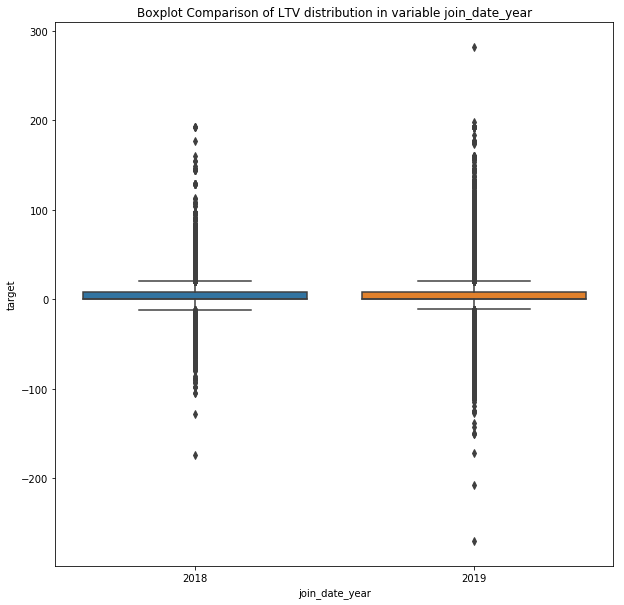

Summary Statistics of LTV according to join_date_year


count      mean        std       min     25%     50%  \
join_date_year                                                            
2018            128788.0  6.510983  14.085821 -174.4742  0.3975  0.3975   
2019            752339.0  6.252387  14.709625 -270.2035  0.3975  0.3975   

                    75%       max  
join_date_year                     
2018            8.30775  192.1515  
2019            8.25000  281.8116

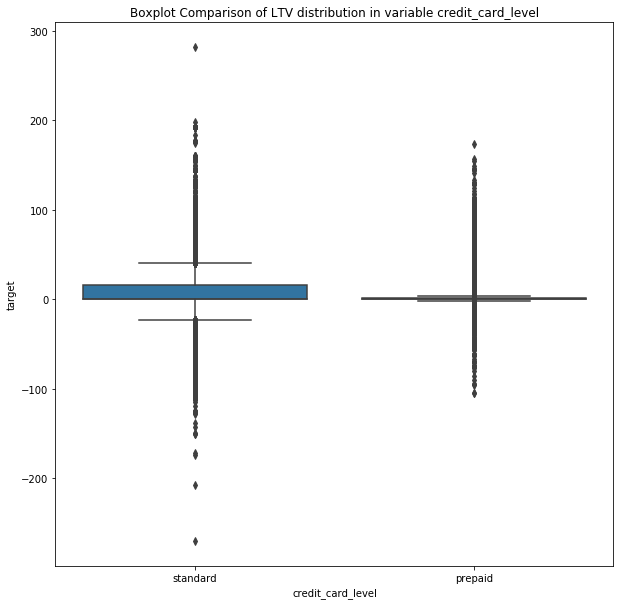

Summary Statistics of LTV according to credit_card_level


count      mean        std       min     25%     50%  \
credit_card_level                                                            
prepaid            351252.0  4.731615  10.758433 -104.8768  0.3975  0.3975   
standard           529875.0  7.323354  16.614752 -270.2035  0.3975  0.7950   

                        75%       max  
credit_card_level                      
prepaid             1.59000  173.7870  
standard           16.27763  281.8116

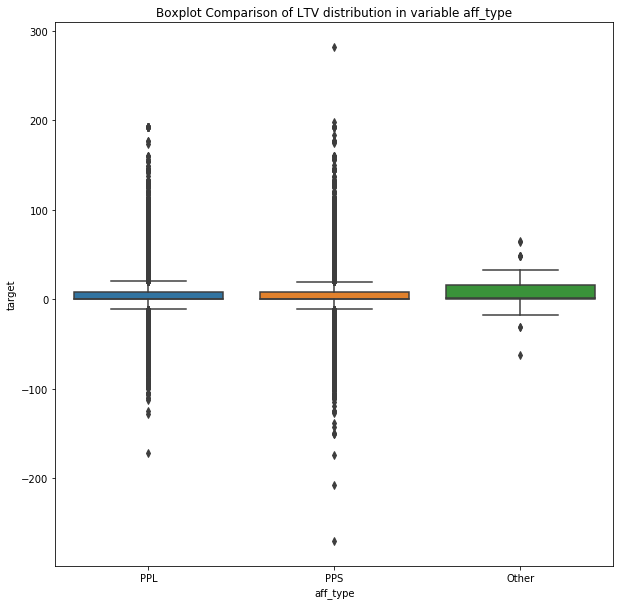

Summary Statistics of LTV according to aff_type


count      mean        std        min     25%     50%       75%  \
aff_type                                                                       
Other        161.0  8.316334  15.955595  -62.39475  0.3975  1.1925  16.27763   
PPL       502717.0  6.292579  14.341653 -171.34670  0.3975  0.3975   8.25000   
PPS       378247.0  6.286163  14.982257 -270.20350  0.3975  0.7950   8.25000   

                max  
aff_type             
Other      64.69313  
PPL       192.15150  
PPS       281.81160

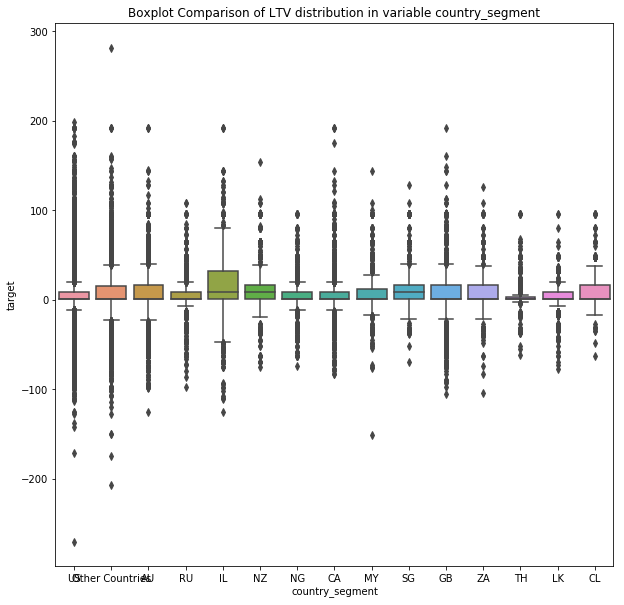

Summary Statistics of LTV according to country_segment


count       mean        std        min     25%     50%  \
country_segment                                                              
AU                33616.0   7.467320  19.016723 -124.78950  0.3975  1.1925   
CA                30267.0   5.953533  14.795781  -82.86975  0.3975  0.3975   
CL                 1139.0   9.852612  17.211003  -62.39475  0.3975  0.7950   
GB                21355.0   8.372682  19.128221 -105.03700  0.3975  0.7950   
IL                 5992.0  17.356988  28.607712 -124.78950  0.3975  8.2500   
LK                 2965.0   3.837513  10.454880  -77.42712  0.3975  0.3975   
MY                 6439.0   7.182146  15.159190 -150.48450  0.3975  0.7950   
NG                14653.0   4.393399  10.872803  -73.83225  0.3975  0.7950   
NZ                 7112.0   9.571773  15.373201  -75.24225  0.3975  8.2500   
Other Countries  106738.0   6.936121  15.973671 -207.05100  0.3975  0.7950   
RU                15369.0   4.533603  10.446254  -97.58450  0.3975  0.7950   
SG                 4152.0   9.949923  18.191634  -69.58450  0.3975  8.2500   
TH                 2841.0   4.437332  10.919481  -61.36975  0.3975  0.3975   
US               624890.0   5.979397  13.780472 -270.20350  0.3975  0.3975   
ZA                 3599.0   7.426256  14.313646 -104.37680  0.3975  1.1925   

                      75%        max  
country_segment                       
AU               16.27763  192.15150  
CA                8.25000  192.15150  
CL               16.27763   96.07575  
GB               16.27763  192.15150  
IL               32.55525  192.15150  
LK                8.25000   96.07575  
MY               12.30263  144.11360  
NG                8.25000   96.07575  
NZ               16.27763  153.53440  
Other Countries  15.88013  281.81160  
RU                8.25000  108.00080  
SG               16.27763  128.63100  
TH                2.78250   96.07575  
US                8.25000  198.05440  
ZA               16.27763  125.76900

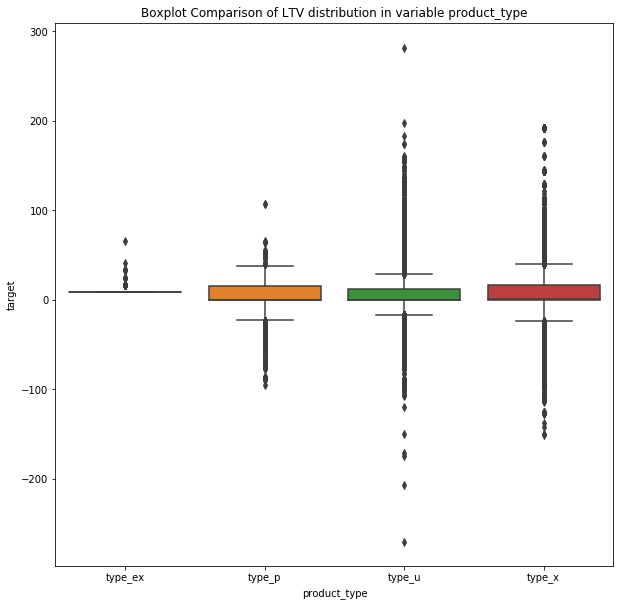

Summary Statistics of LTV according to product_type


count      mean        std        min     25%     50%  \
product_type                                                             
type_ex        73673.0  8.400839   1.155960    8.25000  8.2500  8.2500   
type_p        466844.0  5.138930  12.191131  -95.11475  0.3975  0.3975   
type_u         56554.0  5.782542  15.689363 -270.20350  0.3975  0.3975   
type_x        284056.0  7.735912  19.077975 -150.48450  0.3975  0.7950   

                   75%       max  
product_type                      
type_ex        8.25000   66.0000  
type_p        15.88013  107.5436  
type_u        11.90512  281.8116  
type_x        16.27763  192.1515

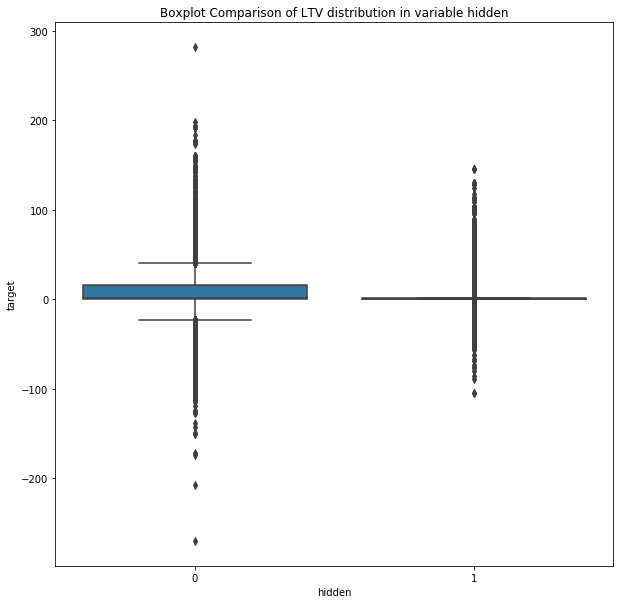

Summary Statistics of LTV according to hidden


count      mean        std       min     25%     50%       75%  \
hidden                                                                      
0       643375.0  7.934808  16.328977 -270.2035  0.3975  1.1925  16.27763   
1       237752.0  1.839707   6.597982 -104.8768  0.3975  0.3975   0.79500   

             max  
hidden            
0       281.8116  
1       145.3061

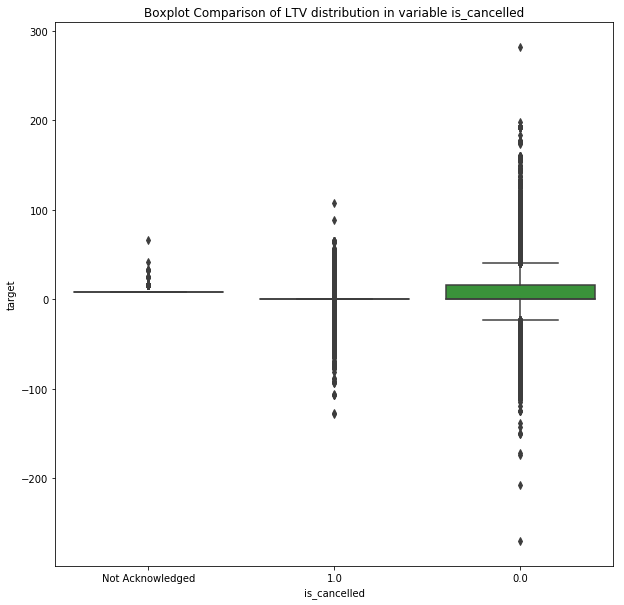

Summary Statistics of LTV according to is_cancelled


count      mean        std       min     25%     50%  \
is_cancelled                                                                
0.0               493980.0  8.959893  18.222141 -270.2035  0.3975  0.7950   
1.0               313474.0  1.587144   6.548043 -127.6696  0.3975  0.3975   
Not Acknowledged   73673.0  8.400839   1.155960    8.2500  8.2500  8.2500   

                       75%       max  
is_cancelled                          
0.0               16.27763  281.8116  
1.0                0.39750  107.5436  
Not Acknowledged   8.25000   66.0000

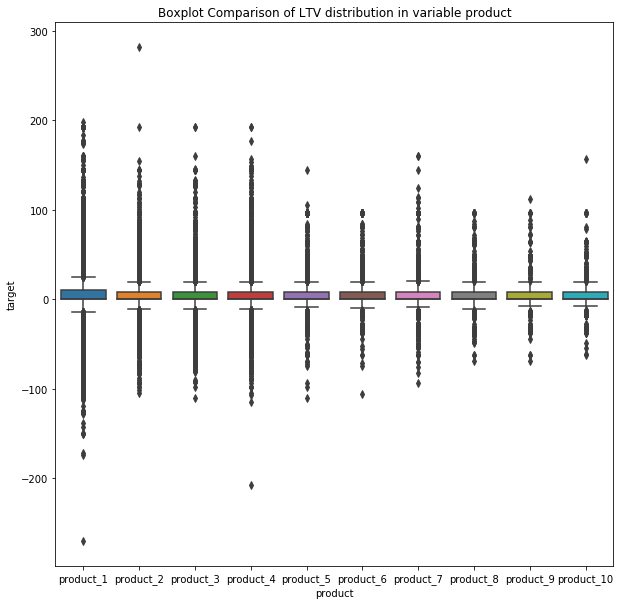

Summary Statistics of LTV according to product


count      mean        std        min     25%     50%  \
product                                                                
product_1   432991.0  6.467636  15.670208 -270.20350  0.3975  0.7950   
product_10    2599.0  6.135796  14.158238  -62.39475  0.3975  0.3975   
product_2   130600.0  6.317332  13.731978 -104.37680  0.3975  0.7950   
product_3    94889.0  5.964149  13.568945 -110.78950  0.3975  0.3975   
product_4   180920.0  6.080224  13.296856 -207.05100  0.3975  0.3975   
product_5    12890.0  5.919787  13.846284 -110.78950  0.3975  0.3975   
product_6     8632.0  5.959360  13.199523 -105.90920  0.3975  0.3975   
product_7    11127.0  6.090449  14.020433  -93.30725  0.3975  0.7950   
product_8     4811.0  5.925053  13.365970  -69.28950  0.3975  0.3975   
product_9     1668.0  6.622016  14.697697  -69.28950  0.3975  0.7950   

                 75%        max  
product                          
product_1   10.31513  198.05440  
product_10   8.25000  157.05220  
product_2    8.25000  281.81160  
product_3    8.25000  192.15150  
product_4    8.25000  192.15150  
product_5    8.25000  144.11360  
product_6    8.25000   96.47325  
product_7    8.25000  160.39130  
product_8    8.25000   96.07575  
product_9    8.25000  112.35340

In [39]:
for category in cat:
    fig = plt.figure(figsize=(10,10))
    sns.boxplot(x=category, y="target", data=ex_2_train)
    plt.title("Boxplot Comparison of LTV distribution in variable {}".format(category))
    plt.show()
    print("Summary Statistics of LTV according to {}".format(category))
    display(ex_2_train.groupby(category)["target"].describe())

Knowing that there are fraudulent users (target < 0), let's check with a chi-squared test for categorical variables. And it's shown that the distribution of fraudulent users is random just when dealing with *aff_type*.

In [40]:
for category in cat:
    stat, p, degrees, perf = stats.chi2_contingency(
        pd.crosstab(ex_2_train[category],ex_2_train["frau"])
    )
    print("The p-value of the chi-squared test between fraudulent new variable and {} is {:.2f},the statistic is {:.2f}".format(category, p, stat))
    

The p-value of the chi-squared test between fraudulent new variable and join_date_labour is 0.00, the statistic is 21.42
The p-value of the chi-squared test between fraudulent new variable and join_date_day is 0.00, the statistic is 36.64
The p-value of the chi-squared test between fraudulent new variable and join_date_month is 0.00, the statistic is 137.51
The p-value of the chi-squared test between fraudulent new variable and join_date_year is 0.00, the statistic is 48.45
The p-value of the chi-squared test between fraudulent new variable and credit_card_level is 0.00, the statistic is 24104.94
The p-value of the chi-squared test between fraudulent new variable and aff_type is 0.32, the statistic is 2.26
The p-value of the chi-squared test between fraudulent new variable and country_segment is 0.00, the statistic is 2109.96
The p-value of the chi-squared test between fraudulent new variable and product_type is 0.00, the statistic is 5950.02
The p-value of the chi-squared test between

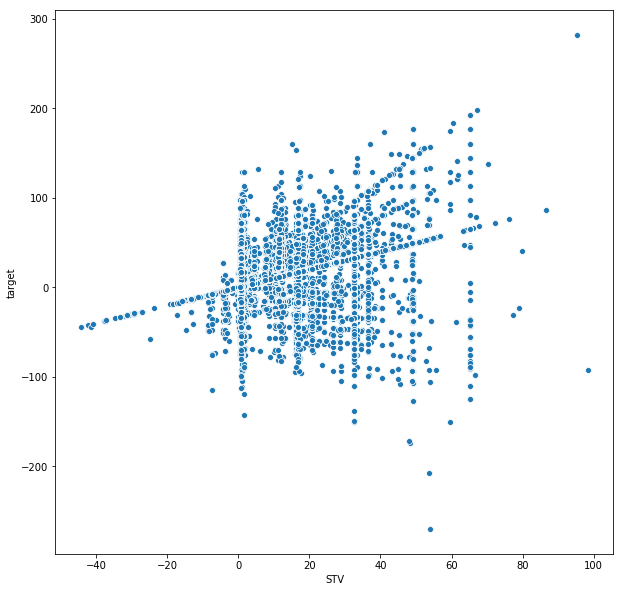

In [83]:
#Execute if you have time
#  p_value = permutation_test(ex_2_train["STV"], ex_2_train["target"],
#                            method='approximate', num_rounds=RESAMPLES,
#                            func=lambda x, y: np.corrcoef(x, y)[1][0],
#                            seed=0)

# Markdown("There's a significant (p_value = {:.2f}) but small positive correlation (Observed Pearson Correlation = {:.2f}) between STC and the target".format(p_value, np.corrcoef(ex_2_train["STV"], ex_2_train["target"])[1][0]))

fig = plt.figure(figsize=(10,10))
# sns.regplot(x="STV", y="target", data=ex_2_train) #Execute if you have time
sns.scatterplot(x="STV", y="target", data=ex_2_train) 
plt.show()

In brief:
- **STV** is correlated with **LTV**. When dealing with *type_ex* product, **STV** and **LTV** are the same. 
- Those registered in *weekend* tend to have a higher **LTV** distribution than in *labour* days.
- There are clear **LTV** distribution difference according to the **credit_card_level**, **hidden** and **is_cancelled**.
- The **LTV** distribution when **aff_type** is *other* is much more robust than the rest of options.
- There are differences between **country_segmentation** in **LTV** distribution.
- *Type_ex* have no frauds, but *type_u* and *type_x* reach the highest and lowest values of **LVT**. When **is_cancelled** is *Not Acknowledged*, there are no frauds.
- With some differences, different **product_type** follow quite similar **LTV** distributions.
- *Fraud* is present and related with all almost all features.

Challenges:
- The historic just reaches 6 months of information, the study of seasonability would be incomplete. And from an external point of view, it's something that should be at least studied.
- There's just information based from the point that they purchase one of them, there's no monitorization.
- There's a "blocking" effect, 1 to 4 (if they buy the 4 types of product) instances come from the same user. *credit_card*, *join_date*, *hidden*, *is_lp*, *aff_type* and *country_segment* follow a direct relationship with the user_id.


### Question 2: Modelization

In order to modelize through the proposed levels of aggregation, I see 4 modellization options that may be interesting:
- **Random Forest Model** using the descriptive variable for every row of information, making an aggreation post-hoc.
- A **Mixed-Effects Linear Model**, considering the user as blocking factor (we just measure the intrinsec variability of the data without the effect of any user). While the product (the choice of the user) is the input value with the *STV*. *{High computational cost}*
- A **Multi-Objective Regression model** for each level of aggregation (or a regression for each level). Using the mean for *LTV* output and for the *STV* input, and the sum for the rest of features. *{To implement}*
- **Recurrent Neural Network (RNN)** using the aggregation of the previous month. This option won't allow to explicitly train the model with the features information, but it will use the intrinsic varibility and tendency of the data through the time. *{To implement}*

To have an insight of the expected test error, I'm using June of 2019 as a validation sample.

In [60]:
ex_2_train.head()

product_type  user_id           join_date  hidden    product   STV  target  \
0      type_ex      7.0 2018-12-01 00:01:45       0  product_1  8.25    8.25   
1      type_ex     20.0 2018-12-01 00:06:05       0  product_2  8.25    8.25   
2      type_ex     22.0 2018-12-01 00:06:23       0  product_3  8.25    8.25   
3      type_ex     26.0 2018-12-01 00:07:12       0  product_2  8.25    8.25   
4      type_ex     59.0 2018-12-01 00:15:21       0  product_2  8.25    8.25   

  credit_card_level  is_lp aff_type      is_cancelled  country_segment  \
0          standard      0      PPL  Not Acknowledged               US   
1          standard      0      PPL  Not Acknowledged               US   
2           prepaid      0      PPL  Not Acknowledged               US   
3          standard      0      PPL  Not Acknowledged               US   
4          standard      0      PPL  Not Acknowledged  Other Countries   

  join_date_all_day  join_date_day join_date_labour  join_date_month  \
0        2018-12-01              5          weekend               12   
1        2018-12-01              5          weekend               12   
2        2018-12-01              5          weekend               12   
3        2018-12-01              5          weekend               12   
4        2018-12-01              5          weekend               12   

   join_date_year  frau  
0            2018  cool  
1            2018  cool  
2            2018  cool  
3            2018  cool  
4            2018  cool

### Random Forest

In [48]:
ex_2_train_encoded = pd.concat([ex_2_train[["STV", "hidden", "is_lp", "target", "join_date_month"]], 
                                pd.get_dummies(ex_2_train[hot_encoders])],
                               axis=1)

train = ex_2_train_encoded[ex_2_train_encoded["join_date_month"]!=6]
val = ex_2_train_encoded[ex_2_train_encoded["join_date_month"]==6]

In [49]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(train.drop(["target", "join_date_month"], 1), train["target"])
y_pred = regressor.predict(val.drop(["target", "join_date_month"], 1))

In [53]:
Markdown("The expected mean absolute error is: {:.4f}".format(mean_absolute_error(val["target"], y_pred)))

The expected mean absolute error is: 6.0910

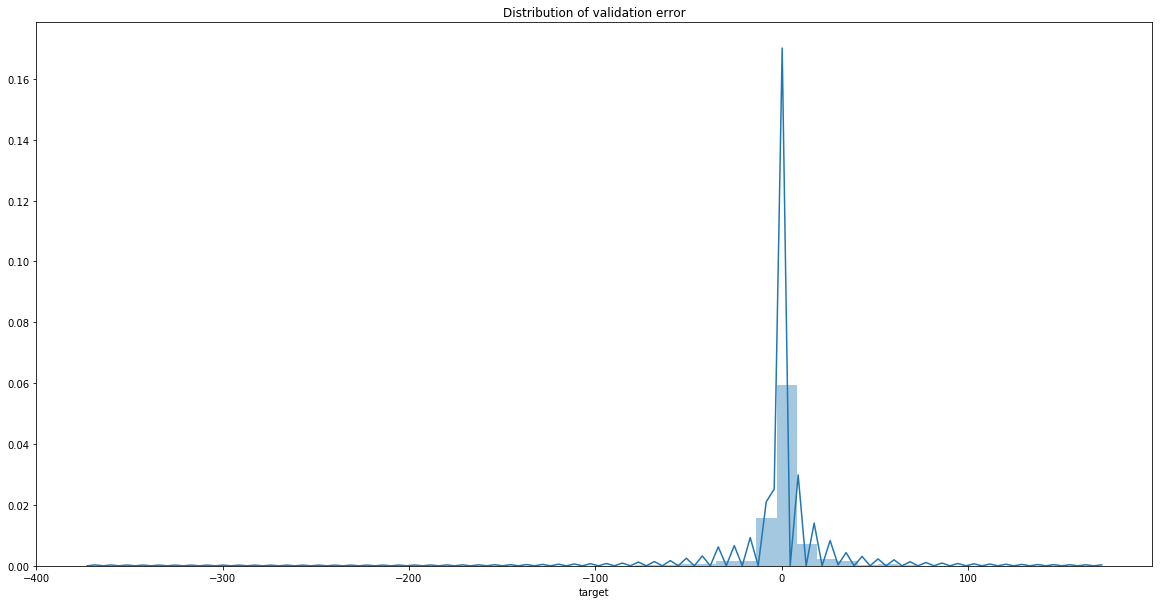

In [55]:
fig = plt.figure(figsize=(20,10))
sns.distplot(val["target"] - y_pred)
plt.title("Distribution of validation error")
plt.show()

### Mixed-Effects Linear Model

In [75]:
train_lme = ex_2_train[ex_2_train["join_date_month"]!=6]
val_lme = ex_2_train[ex_2_train["join_date_month"]==6]

In [78]:
md = smf.mixedlm("target ~ STV * product_type", train_lme, groups=train_lme["user_id"])

mdf = md.fit()

print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    target       
No. Observations:     763023     Method:                REML         
No. Groups:           403455     Scale:                 83.5711      
Min. group size:      1          Log-Likelihood:        -2955570.7640
Max. group size:      4          Converged:             Yes          
Mean group size:      1.9                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -1.284    0.300 -4.283 0.000 -1.872 -0.696
product_type[T.type_p]      2.719    0.300  9.052 0.000  2.130  3.307
product_type[T.type_u]      3.556    0.305 11.678 0.000  2.959  4.153
product_type[T.type_x]      4.230    0.300 14.085 0.000  3.642  4.819
STV                         1.164   

In [84]:
y_pred = mdf.predict(val_lme)

In [85]:
Markdown("The expected mean absolute error is: {:.4f}".format(mean_absolute_error(val_lme["target"], y_pred)))

The expected mean absolute error is: 6.1683

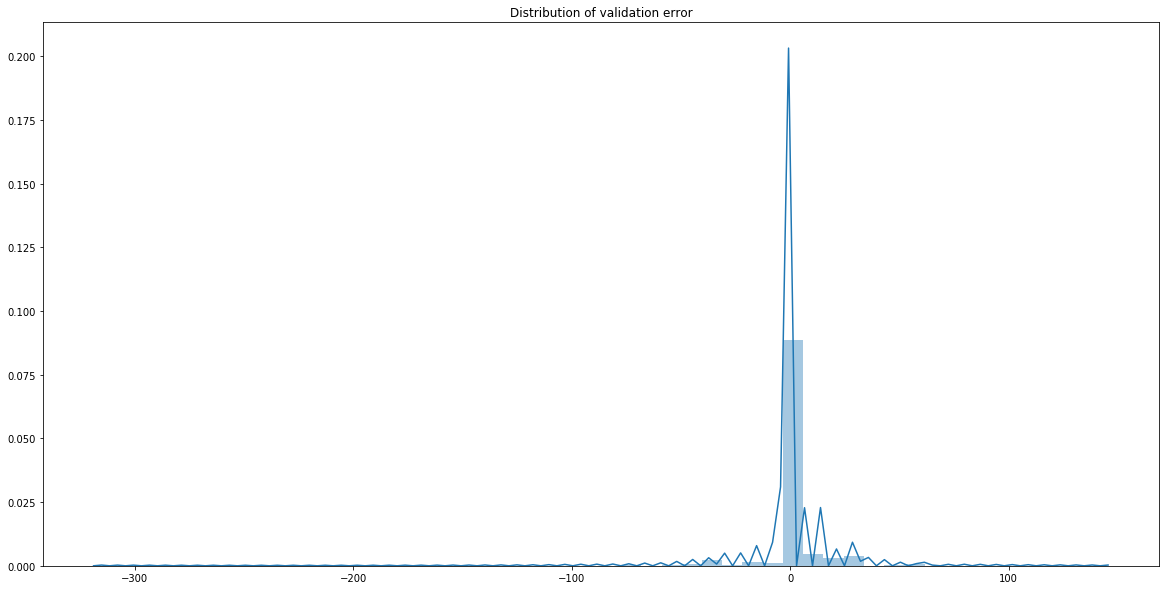

In [86]:
fig = plt.figure(figsize=(20,10))
sns.distplot(val_lme["target"] - y_pred)
plt.title("Distribution of validation error")
plt.show()

This is a really high cost computating model, just in the training sample there are 466.844 different *user_id*. Nonetheless, it would be a great generalization of the model. Once the effect of the user is extracted of the estimations, we could see the voluntary consume effect. Even though the effect the variables that define the user could be included in the model, it would be necessary more computing time to make this model fit.

### Multi Regression

In [46]:
hot_encoders = ["credit_card_level", "aff_type", "product", "is_cancelled"]
ex_2_train_encoded = pd.concat([ex_2_train[["STV", "hidden", "is_lp", "target", "product_type", "country_segment", "join_date_month"]], 
                                pd.get_dummies(ex_2_train[hot_encoders])],
                               axis=1)
train = ex_2_train_encoded[ex_2_train_encoded["join_date_month"]!=6]
val = ex_2_train_encoded[ex_2_train_encoded["join_date_month"]==6]

In [47]:
train_2 = pd.concat([
    train.drop(["STV", "target"], 1).groupby(["join_date_month", "country_segment", "product_type"], as_index=False).sum().reset_index(drop=True),
        train[["STV", "target", "join_date_month", "country_segment", "product_type"]].groupby(["join_date_month", "country_segment", "product_type"], as_index=False).mean().reset_index(drop=True)],
axis=1)

val_2 = pd.concat([
    val.drop(["STV", "target"], 1).groupby(["join_date_month", "country_segment", "product_type"], as_index=False).sum().reset_index(drop=True),
        val[["STV", "target", "join_date_month", "country_segment", "product_type"]].groupby(["join_date_month", "country_segment", "product_type"], as_index=False).mean().reset_index(drop=True)],
axis=1)

There would be a model for each level of aggregation. However, it would be just 7 instances for the training of each regression, and just relationships inside the level of agregations are taken into account.

### RNN

The input would be the aggregated data as a matrix, sequentially for each month that has past. So, each new month will consider the past month to make it's predictions. Furthermore, applying LSTM cells, more months in the past may be considered for the modelization. In addition, the aggregates of the inputs may be passed as input to the same network.

### Question 3: Prediction

Using the **Random Forest** model as a predictor (which has the lowest validation error), the prediction for July 2019 will be exported in the same directory where this notebook is located.

In [71]:
ex_2_test = preprocess_df(ex_2_test)

ex_2_test_encoded = pd.concat([ex_2_test[["STV", "hidden", "is_lp", "join_date_month"]], 
                                pd.get_dummies(ex_2_test[hot_encoders])],
                               axis=1)


In [57]:
ex_2_test["y_pred"] = regressor.predict(ex_2_test_encoded.drop(["join_date_month"], 1))

In [58]:
output = pd.pivot_table(ex_2_test, values='y_pred', index=['join_date_month', 'country_segment'],
                        columns=['product_type'], aggfunc=np.mean)

In [59]:
flattened = pd.DataFrame(output.to_records())
flattened["join_date_month"] = "2019-07-01"
flattened.columns = list(map(lambda x: x.replace("type", "mean_target_type"),flattened.columns))
display(flattened)
flattened.to_csv("prediction_july_19.csv") #The file is located in the same place as this notebook.

join_date_month  country_segment  mean_target_type_ex  mean_target_type_p  \
0       2019-07-01               AU             8.323267            6.144555   
1       2019-07-01               CA             8.577067            4.128641   
2       2019-07-01               CL             8.276641            8.931160   
3       2019-07-01               GB             8.290549            6.605181   
4       2019-07-01               IL             8.350225           18.807309   
5       2019-07-01               LK             8.997680            2.851756   
6       2019-07-01               MY             8.315279            8.407035   
7       2019-07-01               NG             8.272823            4.761893   
8       2019-07-01               NZ             8.523712            9.171644   
9       2019-07-01  Other Countries             8.423352            6.043801   
10      2019-07-01               RU             8.250000            3.464325   
11      2019-07-01               SG             8.250000            7.939925   
12      2019-07-01               TH             8.250000            3.755914   
13      2019-07-01               US             8.570181            4.743371   
14      2019-07-01               ZA             8.527395            9.414361   

    mean_target_type_u  mean_target_type_x  
0             5.772028            9.538233  
1             3.249318            7.292692  
2             9.305576           13.558931  
3             7.807463           12.330849  
4            18.170867           30.344498  
5             3.075457            5.314617  
6             5.693835            8.362665  
7             3.590435            2.948414  
8             7.631575           13.126423  
9             5.592296            8.338001  
10            3.325610            4.100727  
11            8.214276           13.340120  
12            4.327906            5.930852  
13            5.550115            7.977493  
14            7.209653            9.477686

In addition, using the **Mixed-Effects Lineal Model** as a predictor, the prediction for July 2019 will be exported in the same directory where this notebook is located.

In [82]:
ex_2_test["y_pred_lme"] = mdf.predict(ex_2_test)
output = pd.pivot_table(ex_2_test, values='y_pred_lme', index=['join_date_month', 'country_segment'],
                        columns=['product_type'], aggfunc=np.mean)
flattened = pd.DataFrame(output.to_records())
flattened["join_date_month"] = "2019-07-01"
flattened.columns = list(map(lambda x: x.replace("type", "mean_target_type"),flattened.columns))
display(flattened)
flattened.to_csv("prediction_july_19_lme.csv") #The file is located in the same place as this notebook.

join_date_month  country_segment  mean_target_type_ex  mean_target_type_p  \
0       2019-07-01               AU             8.406031            5.629331   
1       2019-07-01               CA             8.729500            4.857772   
2       2019-07-01               CL             8.322853            5.455102   
3       2019-07-01               GB             8.322853            5.766691   
4       2019-07-01               IL             8.422926           10.670200   
5       2019-07-01               LK             9.146313            4.216079   
6       2019-07-01               MY             8.391475            5.756757   
7       2019-07-01               NG             8.348609            4.964569   
8       2019-07-01               NZ             8.637838            7.198768   
9       2019-07-01  Other Countries             8.506610            5.435334   
10      2019-07-01               RU             8.322853            5.105956   
11      2019-07-01               SG             8.322853            7.035700   
12      2019-07-01               TH             8.322853            3.557025   
13      2019-07-01               US             8.681294            4.928233   
14      2019-07-01               ZA             8.648515            6.845974   

    mean_target_type_u  mean_target_type_x  
0             6.452865            9.201207  
1             5.093217            8.199238  
2             5.535990            9.370991  
3             7.189333           10.926734  
4            12.490969           19.861517  
5             4.827931            7.324006  
6             5.293693            8.134565  
7             5.110809            5.324490  
8             7.430248           10.959659  
9             5.739878            7.960135  
10            4.978327            5.789696  
11            6.484044            9.472436  
12            4.218285            6.676856  
13            5.665020            8.060825  
14            6.059467            9.216893

# Personal Notes

Despite of not being able to implement succesfully what was required in the final exercise, I've pointed out the strategies that I would like to follow (in a working environment, discussing with the rest of the team). I would like to ask for feedback in the aspects that you consider wrong or incomplete, I faced a challenge (which I'm interested into) and with your clarifications I will learn from my errors.

Of course, I'm fully aware that this document could be a lot prettier, also including references and explanations. However, with my actual schedule, the time I was able to invest in this test was limited (1.5 workdays), and I tried to make it as good and clear as possible. I would have liked to explore some multivariate techniques to go beyond bivariate relationships, performins some clustering, and then, implement the rest of the models optimizing the hyperparameters with cross-validation. 

Best regards!